## Ligand Receptor Interaction Survival Analysis 

By Tiago Maié and James Nagai

Here we introduce the survival model analysis used to the orthogonal validation of the scACCorDiON subcluters.

### For installing the R package use
```{r}
pak::pak("CostaLab/scACCorDiON.su")
```

In [1]:
library(scACCorDiON.su)
library(IRdisplay) ## Tables rendering 
library(reactable) ## Tables display


---------------------------------
scACCorDiON.su version 0.0.0.9000
---------------------------------



### Loading the data used in the PDAC experiment

In [2]:
data(pdac_cci_data)
data(paad_tcga_clinical_data) ## TCGA data
data(paad_tcga_expression_data) ## TCGA data
data(comparison_of_interest) ## Here he have the desired interaction

### Interaction: DCT2 and DCT1 were renamed in the paper for the readability, Malignant Ductal and Ductal cell, respectivelly

In [3]:
comparison_of_interest

[1] "Ductal.cell.type.2_Ductal.cell.type.1"

### Reading CrossTalkeR sankey data (Supp. Fig. 8)

Here we can supply ligand receptor interactions for the PDAC data

In [4]:
lrsankey <- read.csv("../../../scaccordion/data/PDAC_differential.csv")

*Note:* table must be names as the example below

In [5]:
head(lrsankey[,c("source","target","gene_A","gene_B","LRScore")]) 

,source,target,gene_A,gene_B,LRScore
,<chr>,<chr>,<chr>,<chr>,<dbl>
1,Ductal cell type 2,Macrophage cell,B2M|L,CD1C|R,-2.578362
2,Endocrine cell,B cell,INS|L,LILRB1|R,-2.548423
3,Ductal cell type 2,B cell,B2M|L,CD1C|R,-2.495319
4,B cell,B cell,APP|L,CD74|R,-2.422047
5,B cell,B cell,COPA|L,CD74|R,-2.386160
6,T cell,B cell,COPA|L,CD74|R,-2.381791


## Preparing the data from the sankey plot to perform survival analysis(Table 4)

Here, the data is prepared to be used in the **run_survival** funtion. We first select the source and target interaction. Second, HLA genes are filtered. Finally, we filter the overlapping communication gened and select the top 10

In [6]:
pairs <- lrsankey |>
            dplyr::filter(grepl("Ductal cell type 2",source))|>
            dplyr::filter(grepl("Ductal cell type 1",target)) |>
            dplyr::filter(!grepl("HLA-",gene_A)) |>
            dplyr::mutate(ligand=gsub("\\|L","",gene_A)) |>
            dplyr::mutate(receptor=gsub("\\|R","",gene_B)) |>
        	dplyr::filter(ligand %in% paad_tcga_expression_data$symbol) |>
        	dplyr::filter(receptor %in% paad_tcga_expression_data$symbol) |>
            dplyr::slice_max(n=10,order_by = LRScore,with_ties = FALSE) |>
            dplyr::select(ligand,receptor)

Once this analysis were dont comparing PDAC2_x_PDAC1 the highest LRscores are associated to interactions that are highly expressed in PDAC1

### LR Survival

In [7]:
results <-
  run_survival(
    comparison_oi = comparison_of_interest,
    lr_data = pdac_cci_data,
    tcga_exp_data = paad_tcga_expression_data,
    tcga_clinical_data = paad_tcga_clinical_data,
    selection_method = c("limma"),
    custom_selection = pairs,
    n_lr_selected = 10,
    which_get = c("ligand", "receptor"),
    is_signif = TRUE,
    clinical_vars_in_model = c("stage")
  )
#> Warning: Zero sample variances detected, have been offset away from zero
results$cox_models$coxph_clinical.lr_pairs |>
  broom::tidy() |>
  dplyr::mutate(issignif=p.value<0.05) |>
  dplyr::arrange(p.value)

term,estimate,std.error,statistic,p.value,issignif
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
C3_CD81,0.68281413,0.2405836,2.83815732,0.004537481,TRUE
MMP7_SDC1,0.34164611,0.1228055,2.78201000,0.005402338,TRUE
CD99_CD81,-0.85402299,0.3603318,-2.37010188,0.017783184,TRUE
TIMP1_FGFR2,-0.35078021,0.1691310,-2.07401532,0.038077889,TRUE
S100A4_ERBB3,0.19078558,0.1240457,1.53802602,0.124042254,FALSE
TIMP1_CD63,-0.35190580,0.2511306,-1.40128581,0.161128624,FALSE
COPA_CD74,-0.45817603,0.4770598,-0.96041631,0.336845731,FALSE
LAMB2_RPSA,-0.28067665,0.3610970,-0.77728880,0.436988400,FALSE
stageStage_IV,-0.40601192,0.8660926,-0.46878582,0.639222740,FALSE


### Ligand only survival

In [8]:
results <-
  run_survival(
    comparison_oi = comparison_of_interest,
    lr_data = pdac_cci_data,
    tcga_exp_data = paad_tcga_expression_data,
    tcga_clinical_data = paad_tcga_clinical_data,
    selection_method = c("limma"),
    custom_selection = pairs,
    n_lr_selected = 10,
    which_get = c("ligand"),
    is_signif = TRUE,
    clinical_vars_in_model = c("stage")
  )
#> Warning: Zero sample variances detected, have been offset away from zero
results$cox_models$coxph_clinical.gene_expression |>
  broom::tidy() |>
  dplyr::mutate(issignif=p.value<0.05)  |>
  dplyr::arrange(p.value)

term,estimate,std.error,statistic,p.value,issignif
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
MMP7,0.15541109,0.07010018,2.2169857,0.02662407,TRUE
TIMP1,-0.42764750,0.19417184,-2.2024178,0.02763581,TRUE
C3,0.18124162,0.11222101,1.6150418,0.10630165,FALSE
LAMB2,-0.35228823,0.25350917,-1.3896469,0.16463612,FALSE
S100A4,0.10312685,0.07768648,1.3274749,0.18435162,FALSE
CD99,-0.23579445,0.22318141,-1.0565147,0.29073312,FALSE
COPA,-0.12465043,0.35093778,-0.3551924,0.72244547,FALSE
LGALS3BP,-0.05654436,0.21479237,-0.2632513,0.79235693,FALSE
stageStage_II,0.08568917,0.45425232,0.1886378,0.85037668,FALSE


### Receptor only survival

In [9]:
results <-
  run_survival(
    comparison_oi = comparison_of_interest,
    lr_data = pdac_cci_data,
    tcga_exp_data = paad_tcga_expression_data,
    tcga_clinical_data = paad_tcga_clinical_data,
    selection_method = c("limma"),
    custom_selection = pairs,
    n_lr_selected = 10,
    which_get = c("receptor"),
    is_signif = TRUE,
    clinical_vars_in_model = c("stage")
  )
#> Warning: Zero sample variances detected, have been offset away from zero
results$cox_models$coxph_clinical.gene_expression |>
  broom::tidy() |>
  dplyr::mutate(issignif=p.value<0.05) |>
  dplyr::arrange(p.value)

term,estimate,std.error,statistic,p.value,issignif
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
ERBB3,0.36558947,0.1570826,2.32737151,0.01994550,TRUE
RPSA,0.52221276,0.2247357,2.32367477,0.02014293,TRUE
ITGB1,0.42528859,0.1852087,2.29626672,0.02166064,TRUE
CD63,-0.59015033,0.2715733,-2.17307933,0.02977435,TRUE
SDC1,0.17801006,0.1223412,1.45502967,0.14566105,FALSE
FGFR2,-0.12429890,0.1015618,-1.22387418,0.22099970,FALSE
CD81,-0.22181624,0.1813146,-1.22337804,0.22118694,FALSE
CD74,0.15656289,0.1485338,1.05405534,0.29185758,FALSE
stageStage_IV,-0.56158409,0.8621951,-0.65134221,0.51482561,FALSE


## Finding survival hits without custom Selection

In [10]:
results <-
  run_survival(
    comparison_oi = comparison_of_interest,
    lr_data = pdac_cci_data,
    tcga_exp_data = paad_tcga_expression_data,
    tcga_clinical_data = paad_tcga_clinical_data,
    selection_method = c("limma"),
    n_lr_selected = 30,
    which_get = c("ligand", "receptor"),
    is_signif = TRUE,
    clinical_vars_in_model = c("stage")
  )
#> Warning: Zero sample variances detected, have been offset away from zero
results$cox_models$coxph_clinical.lr_pairs |>
  broom::tidy() |>
  dplyr::mutate(issignif=p.value<0.05)  |>
  dplyr::arrange(p.value)

Warning message:
“Zero sample variances detected, have been offset away from zero”


term,estimate,std.error,statistic,p.value,issignif
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
WNT10A_FZD1,4.804240612,2.15116680,2.23331850,0.02552795,TRUE
WNT7B_FZD5,4.710718428,2.11236817,2.23006505,0.02574312,TRUE
FGF2_SDC3,-0.961084335,0.44546094,-2.15750528,0.03096632,TRUE
WNT7B_FZD1,-4.223638197,1.98969477,-2.12275685,0.03377423,TRUE
WNT7A_FZD5,-2.237014428,1.14867741,-1.94746968,0.05147845,FALSE
WNT7A_FZD6,2.182546446,1.12241215,1.94451426,0.05183347,FALSE
AMH_EGFR,-0.086740102,0.04518292,-1.91975444,0.05488892,FALSE
FGF2_GPC4,0.642919258,0.36467082,1.76301264,0.07789836,FALSE
ADAM17_ERBB4,-0.429356492,0.27402613,-1.56684506,0.11715091,FALSE


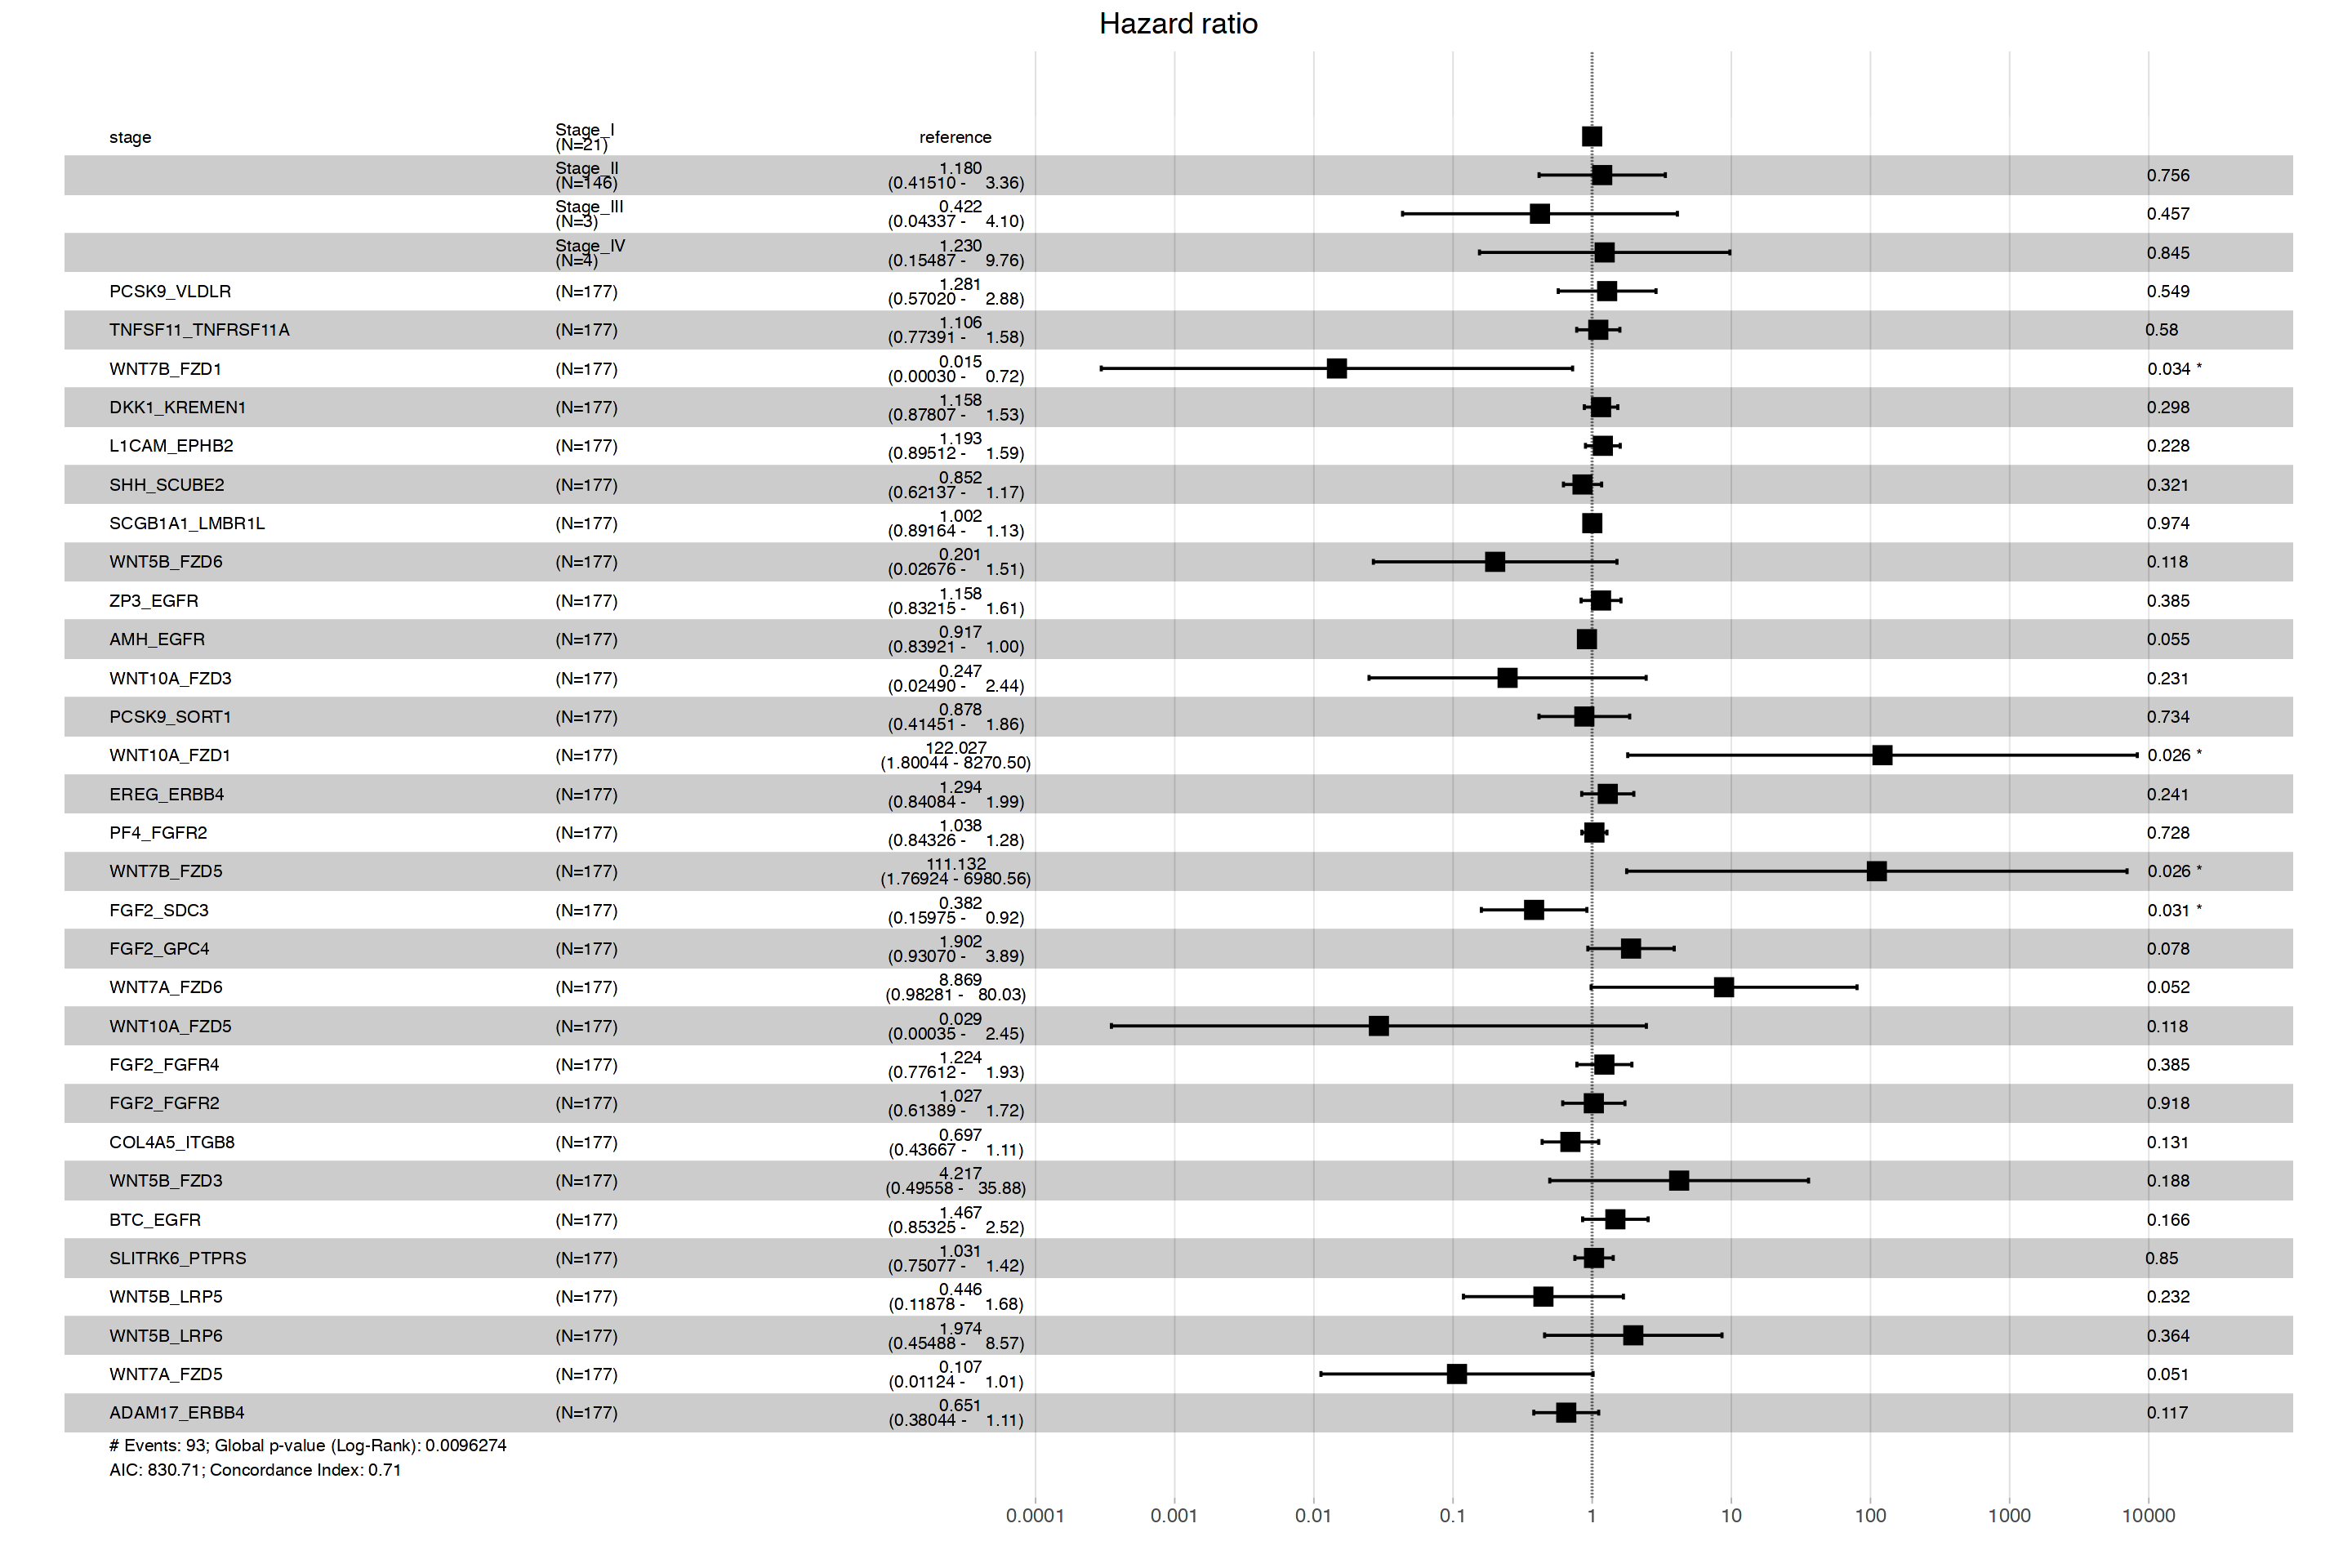

In [16]:
options(repr.plot.width=15,repr.plot.height=10,repr.plot.res=192)
survminer::ggforest(results$cox_models$coxph_clinical.lr_pairs,results$model_data)
